# Aerodynamic lens pressures for AFL-100

---
__Goal__

We want to determine the nozzle pressure (i.e. the pressure upstream of the last orifice of the aerodynamic lens). This will enable us to determine the Stokes number. This will help us to check our results from aerosol particle tracking for consitency and compare to literature.

---

In [1]:
# Import modules
%pylab inline
import scipy.constants

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Unit conversions
SI_to_mg_per_min = lambda v: v*1E6*60.
SI_to_mbar = lambda v: v/100.
mbar_to_SI = lambda v: v*100.
SI_to_mm = lambda v: v*1E3

### _Flags_

In [3]:
do_checks = False

## Lens geometry

![title](afl100.png)

In [4]:
# AFL100
# Orifice diameters [m]
D_lenses = asarray([5.1, 4.1, 3.5, 2.9, 2.9, 7.75, 1.5])*1E-3
# Tube diameters [m]
D_tubes  = asarray([17.85, 17.85, 17.85, 17.85, 17.85, 17.85, 7.75, 7.75])*1E-3
# Spacer lengths [m] (will not be needed in these calculations)
L_spacers = asarray([57.15, 57.15, 57.15, 57.15, 57.15, 69.85, 25.6])*1E-3

### _Fixed gas properties_

In [5]:
# Temperature (room temp.) [K]
T = 293.

### _Physical constants_

In [6]:
# Ratio of specific heats cp/cv
gamma = 1.67
# Molar mass [kg]
M = 4.002602E-3
# Gas constant
R = scipy.constants.R
# Boltmann constant
kB = scipy.constants.k

### _Properties for He_

In [7]:
# Ideal gas law
rho = lambda p: p * M / (R * T) # Ideal gas
# Sutherland's law
# Dynamic viskosity (https://en.wikipedia.org/wiki/Viscosity)
T_mu = 273.
mu_mu = 19E-6
C_mu = 79.4
mu = lambda T: mu_mu * (T_mu + C_mu)/(T + C_mu) *(T/T_mu)**(3/2.)
# Gas density at standard conditions
rho0 = rho(p=1E5)
# Collistion molecule diameter
d_molecule = 2.6E-10
# Most common gas molecule velocity (Boltzmann gas)
v0 = sqrt(2 * kB * T / (M / scipy.constants.N_A))

### _Gauge correction for He_

In [8]:
# Gauge correction factor for chamber pressure
gauge_correction_factor_chamber = 0.18
# Gauge correction factor for injector pressure
# http://www.thinksrs.com/downloads/PDFs/ApplicationNotes/IG1pggasapp.pdf
_p_N_reading = [1.33322,
                2.66644,
                3.99966,
                5.33288,
                6.6661,
                7.99932,
                9.33254,
                10.66576,
                11.99898,
                13.3322,
                14.66542]
_p_He_actual = [1.33322*1.1,
                2.133152,
                2.66644,
                3.199728,
                3.599694,
                3.733016,
                3.99966,
                4.132982,
                4.266304,
                4.799592,
                6.6661]
p_He = lambda p_N_reading: (np.where(p_N_reading < 1.33322, 1.1 * p_N_reading,
                                     np.interp(p_N_reading,
                                               _p_N_reading,
                                               _p_He_actual)))

## Chamber pressure as a function of injector pressure

In [9]:
# Data set 1 from Johan 
# Chamber pressure (not gauge corrected for He!)
p_ch_1  = asarray([1.2, 1.9, 2.5, 3.4, 4.6, 5.4, 6.3, 7.4, 8.6, 10.]) * 1E-5 * 100. / gauge_correction_factor_chamber # Pa
# Injector pressure (gauge corrected for He)
p_inj_1 = asarray([p_He(p) for p in [0.031, 0.34, 0.61, 0.99, 1.37, 1.83, 2.88, 4., 5.5, 6.97]]) * 100. # Pa

In [10]:
# Linear interplation formulas
p_ch_interp = lambda p_inj: interp(p_inj, p_inj_1, p_ch_1)
p_inj_interp = lambda p_ch: interp(p_ch, p_ch_1, p_inj_1)

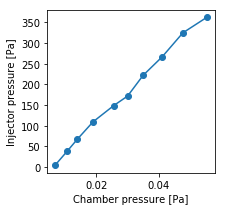

In [11]:
figsize(3,3)
plot(p_ch_1, p_inj_1, "o-")
xlabel("Chamber pressure [Pa]")
ylabel("Injector pressure [Pa]")
if do_checks:
    # Check interpolation formula
    axvline(1.E-4*100, color="black", ls="--")
    axhline(p_inj_interp(1.E-4*100.), color="black", ls="--")

## Mass flow measurements vs. mass flow prediction by Wang's Lens Calculator

In [12]:
# Data set 2 from Johan 
# Chamber pressure (gauge corrected for He)
p_ch_2 = asarray([3.0, 7.4, 10.])*1E-5 * 100. / gauge_correction_factor_chamber # Pa
# Injector pressure (not gauge corrected for He!)
p_inj_2 = asarray([p_inj_interp(p) for p in p_ch_2]) # Pa
# Volume flow for gas at standard conditions
vol_flow_2 = asarray([0.013, 0.07, 0.11]) * 1E-3/60. # slm * 1E-3/60. = m3/sec
# Mass flow for gas assuming gas at standard conditions
mass_flow_2 = vol_flow_2 * rho0 # kg/sec
print p_inj_2, p_ch_2

[  90.32222222  266.6576      363.0084    ] [ 0.01666667  0.04111111  0.05555556]


In [13]:
# Lens calculator result (not availale for lowest pressure because Kn > 0.1)
vol_flow_2_lenscal = asarray([nan, 0.0561, 0.0954]) * 1E-3/60. # slm * 1E-3/60. = m3/sec
# Mass flow for gas assuming gas at standard conditions
mass_flow_2_lenscal = vol_flow_2_lenscal * rho0 # kg/sec

In [14]:
# Interpolation formulas
vol_flow_interp = lambda p_inj: interp(p_inj, p_inj_2, vol_flow_2)
mass_flow_interp = lambda p_inj : interp(p_inj, p_inj_2, mass_flow_2)

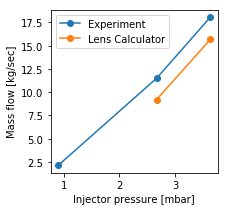

In [15]:
plot(p_inj_2/100., SI_to_mg_per_min(mass_flow_2), "-o", label="Experiment")
plot(p_inj_2/100., SI_to_mg_per_min(mass_flow_2_lenscal), "-o", label="Lens Calculator")
xlabel("Injector pressure [mbar]")
ylabel("Mass flow [kg/sec]")
legend()
if do_checks:
    # Check interpolation formula
    axvline(1., color="black", ls="--")
    axhline(SI_to_mg_per_min(mass_flow_interp(1*100.)), color="black", ls="--")

## Reynolds number

$\text{Re} = \frac{\rho_1 u d_f}{\mu} = \frac{4 \dot{m}}{\pi \mu d_f}$ (Wang 2005, eq. 5)

In [16]:
# Reynolds number
Re = lambda D_lens, mass_flow: 4 * mass_flow / (pi * mu(T=T) * D_lens) # Wang 2005 eq. 5

(0.41077955942835181, 800.0)

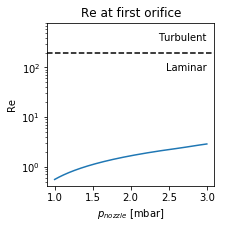

In [17]:
title("Re at first orifice")
p_up_arr = linspace(100, 300, 1000)
Re_arr = Re(D_lens=D_lenses[0], mass_flow=mass_flow_interp(p_up_arr))
plot(SI_to_mbar(p_up_arr), Re_arr)
xlabel("$p_{nozzle}$ [mbar]")
ylabel("Re")
yscale("log")
# Transition by Wang, 2006, eq. 1
Re_crit = 200.
axhline(Re_crit, ls="--", color="black")
text(3.0, Re_crit/2, "Laminar", va="center", ha="right")
text(3.0, Re_crit*2, "Turbulent", va="center", ha="right")
ylim(None, Re_crit*4)

## Knudsen number (Wang)

Nozzle pressure maybe high enough for $Kn > 0.1$?

In [18]:
# Mean free path of gas molecules
mean_free_path = lambda p: (kB * T)/(sqrt(2)*pi*d_molecule**2*p)
# Knudsen number as defined by Wang 2006, eq. 3
Kn = lambda p, D_lens: 2*mean_free_path(p)/D_lens

Knudsen number at the exit nozzle as a function of the nozzle pressure $p_\text{nozzle}$.

(0.001, 35832.567049030746)

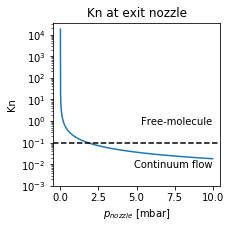

In [19]:
title("Kn at exit nozzle")
p_up_arr = linspace(1E-3, 1000, 1000)
plot(SI_to_mbar(p_up_arr), Kn(p_up_arr, D_lenses[-1]))
xlabel("$p_{nozzle}$ [mbar]")
ylabel("Kn")
yscale("log")
# Transition limit by Wang
Kn_crit = 0.1
axhline(Kn_crit, ls="--", color="black")
text(10.0, Kn_crit/10, "Continuum flow", va="center", ha="right")
text(10.0, Kn_crit*10, "Free-molecule", va="center", ha="right")
ylim(Kn_crit/100, None)

## Rarification parameter $\delta$ (Sharipov)

In [20]:
# Rarification parameter by Sharipov
rarif = lambda p, D_lens: D_lens/2 * p / (mu(T=T) * v0)

(1.6147519513544895e-05, 10000.0)

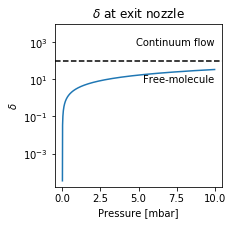

In [21]:
title("$\delta$ at exit nozzle")
p_up_arr = linspace(1E-3, 1000, 1000)
plot(SI_to_mbar(p_up_arr), rarif(p_up_arr, D_lenses[-1]))
yscale("log")
xlabel("Pressure [mbar]")
ylabel("$\delta$")
# Transition limit by Sharipov
rarif_crit = 100.
axhline(rarif_crit, ls="--", color="black")
text(10.0, rarif_crit*10, "Continuum flow", va="center", ha="right")
text(10.0, rarif_crit/10, "Free-molecule", va="center", ha="right")
ylim(None, rarif_crit*100)

## 1) Mass flow through an orifice: Wang, 2005

Limited to $Kn<0.1$ and $Re\le200$!

The hydrodynamic mass flow equation (Wang, 2005) eq. 4:

$\dot{M} = A_f \frac{C_d Y(p_0, p_1)}{\sqrt{1-\beta^4}} \sqrt{2 \rho (p_1-p_0) }$
  
- The orifice area $A_f$ is defined with the diameter $D$ of the orifice as

    $A_f = \pi (D/2)^2$
    
    
- The constriction ratio is the diameter $D$ of the orifice divided by the diameter $T$ of the tube.

    $\beta = \frac{D}{T}$
    

- Expansion factor (Bean, 1971):

    $Y(p_0, p_1) = 1 - (0.410 + 0.350 \beta^4) \frac{p_1-p_0}{\gamma p_0}$

### 1.1) Discharge coefficient

This is taken directly from eq. 7 of Wang, 2005.

In [22]:
def C_d(Re):
    if Re < 11.1: # Better than 12
        return (0.1373*Re**0.5)
    elif Re < 5000:
        return (1.118 - 0.8873 * log(Re) +
                0.3953 * log(Re)**2 -
                0.07081 * log(Re)**3 +
                0.005551 * log(Re)**4 -
                0.0001581 * log(Re)**5)
    else:
        return 0.59

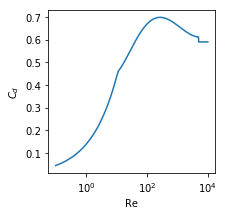

In [23]:
Re_arr = 10**(linspace(-1, 4, 1000))
Cd_arr = asarray([C_d(r) for r in Re_arr])

figsize(3,3)
plot(Re_arr, Cd_arr)
xscale('log')
xlabel("Re")
ylabel("$C_d$")

### 1.2) Mass flow

In [24]:
Y = lambda p0, p1, beta: 1 - (0.410 + 0.350 * beta**4) * (p0-p1)/p0/gamma
mass_flow_wang = lambda p0, p1, Re, Af, beta: Af * C_d(Re=Re) * Y(p0=p0, p1=p1, beta=beta) / sqrt(1-beta**4) * \
                                                sqrt(2 * rho(p=p0) * (p0-p1))    

### 1.3) Post-nozzle pressure

In [25]:
# Predict pressure after the nozzle:
# The solution of eq. 4 gets messy for p_1 - therefore I solve it numerically by interpolation.
def p1_wang(mass_flow1, p0, D_lens, D_tube, do_plot=False):
    Af_fixed = pi*(D_lens/2.)**2
    beta_fixed = D_lens/D_tube
    Re_fixed = Re(D_lens, mass_flow1)
    p1_arr = linspace(0, p0, 1000000)
    mf = mass_flow_wang(p0=p0, p1=p1_arr, Re=Re_fixed, Af=Af_fixed, beta=beta_fixed)
    order = mf.argsort()
    p1_interp = interp(mass_flow1, mf[order], p1_arr[order])
    if do_plot:
        figure()
        plot(p1_arr, mf)
        axhline(mass_flow1, color="black", ls="--")
        axvline(p1_interp, color="black", ls="--")
        xlabel("Pressure downstream [Pa]")
        ylabel("Mass flow rate [kg/sec]")
    if p1_interp == p1_arr[-1]:
        return nan
    return p1_interp

___Simple example___

Fix conditions to
p_0: 1.500 mbar
D_lens: 5.10 mm
D_tube: 17.85 mm
Mass flow: 8.842336e-08 kg/sec (5.305401 mg/min)
Re = 1.1
RESULT: p_1 = 1.482 mbar


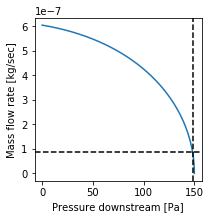

In [26]:
# Fix conditions for example
i_lens_fixed = 0
D_lens_fixed = D_lenses[i_lens_fixed]
D_tube_fixed = D_tubes[i_lens_fixed]
beta = lambda D_lens, D_tube: D_lens/D_tube
beta_fixed = beta(D_lens=D_lens_fixed, D_tube=D_tube_fixed)
Af_fixed = pi*(D_lens_fixed/2.)**2
p0_fixed = mbar_to_SI(1.5) # Pa
mass_flow_fixed = mass_flow_interp(p_inj=p0_fixed) # kg/sec
Re_fixed = Re(D_lens=D_lens_fixed, mass_flow=mass_flow_fixed)
print "Fix conditions to"
print "p_0: %.3f mbar" % SI_to_mbar(p0_fixed)
print "D_lens: %.2f mm" % SI_to_mm(D_lens_fixed)
print "D_tube: %.2f mm" % SI_to_mm(D_tube_fixed)
print "Mass flow: %e kg/sec (%f mg/min)" % (mass_flow_fixed, SI_to_mg_per_min(mass_flow_fixed))
print "Re = %.1f" % Re_fixed

p1_arr = linspace(0., 20., 1000000)
p1 = p1_wang(mass_flow1=mass_flow_fixed, p0=p0_fixed, D_lens=D_lens_fixed, D_tube=D_tube_fixed, do_plot=True)

print "RESULT: p_1 = %.3f mbar" % SI_to_mbar(p1)

## 2) Mass flow through an orifice: Sharipov, 2004

### 2.1) Free-molecule regime ($\delta=0$)

Sharipov cites for this formula for the mass flow rate at $\delta=0$ Bird, 1994:

$\dot{M}_0 = \frac{A_f}{v_0} P_0$

### 2.2) Near the free-molecule regime ($0<\delta<100$)

Sharipov derives an empirical formula from his numerical results for rarified conditions $0<\delta<10$ near the free-molecule regime ($\delta=0$).

The reduced mass flowrate:

$W = \frac{\dot{M}}{\dot{M}_0} = \left( 1 - \frac{P_1}{P_0} \right) \left( 1 + A_{P_1/P_2} \delta \right)$ 

$A_{P_1/P_2}$ is an emprically determined parameter, which is a function of the pressure ratio.

### 2.3) Hydrodynamic regime ($\delta\gg1$)

For the hydrodynamic ($\delta \gg 1$) and isoentropic ($Re \ll 1$) regime mass flow can be described using the Euler equation and this results in the following set of equations (Sharipov, 2004):

Critical pressure ratio:

$\left(\frac{P_1}{P_0}\right)^* = \left( \frac{2}{\gamma+1} \right)^{\gamma/(\gamma-1)}$

- __Not choked__:

    $\frac{P_1}{P_0}>\left(\frac{P_1}{P_0}\right)^*$ 

    $\dot{M} = 2 C \dot{M}_0 \left( \frac{P_1}{P_0} \right)^{1/\gamma} 
        \left[ \frac{\pi\gamma}{\gamma-1}
        \left( 1-\frac{P_1}{P_0} \right)^{(\gamma+1)/2} 
        \right]^{1/2}$


- __Choked regime__: 
    
    $\frac{P_1}{P_0}\le \left(\frac{P_1}{P_0}\right)^*$ 
    
    $\dot{M}_n = C \dot{M}_0 \sqrt{2 \pi \gamma} \left( \frac{2}{\gamma + 1} \right)^{\frac{\gamma+1}{2(\gamma-1)}}$
    
The discharge coefficient (different from Wang's definition) is a correction factor for orifice flow (i.e. special case of nozzle flow) and depends on the orifice dimensions and $\gamma$. I use the value 0.853 from Jitschin et al., 1999 for He and $L/a=0.0162$.

In [27]:
# Critical pressure ratio for He
ratio_c = (2./(gamma+1))**(gamma/(gamma-1))
print "Critical pressure ratio for He: %f" % ratio_c

Critical pressure ratio for He: 0.486669


In [28]:
# Jitschin, 1999 for our kind of nozzles (see comment above)
C_d_jitschin = 0.853 

In [29]:
# Empirical parameter interpolation for close to molecular-flow formula
_A_A_sharipov = asarray([0.13, 0.15, 0.23, 0.31])
_A_ratio_sharipov = asarray([0.0, 0.1, 0.5, 0.9])
A_sharipov = lambda ratio: interp(ratio, _A_ratio_sharipov, _A_A_sharipov)

In [35]:
# Mass flow rate rate prediction
def mass_flow_sharipov(p0, p1, D_lens, verbose=False):
    errs = []
    mfns = []    
    _delta = rarif(p=p0, D_lens=D_lens)
    ratio = p1/p0
    mf0 = sqrt(pi)*(D_lens/2.)**2 / v0 * p0
    if _delta <= 100.:
        if verbose:
            print "Free-molecule regime"
        # Close to free-molecule regime
        W = (1.-ratio)*(1+A_sharipov(ratio=ratio)*_delta)
        mfn = W * mf0
    else:
        if verbose:
            print "Hydrodynamic regime"
            if ratio > ratio_c:
                print "Not choked"
            else:
                print "Choked"
        if ratio > ratio_c:
            # Not choked
            mfn = C_d_jitschin * 2 * mf0 * (p1/p0)**(1./gamma) * sqrt(pi*gamma/(gamma-1)*(1-(p1/p0)**((gamma+1)/2.)))
        else:
            # Choked
            mfn = C_d_jitschin * mf0 * sqrt(2*pi*gamma) * (2./(gamma+1))**((gamma+1)/(2*(gamma-1)))
        _Re = Re(D_lens=D_lens, mass_flow=mfn)
        if _Re < 10:
            print "WARNING: Incorrect assumption. Flow not isoentropic (Re = %f < 10) and hence Euler equation invalid." % _Re
            return nan
    return mfn

### 2.4 "Propagate" pressure through orifice by interpolation

In [36]:
def p1_sharipov(p0, mfn, D_lens, verbose=False, do_plot=False):
    p1_arr = linspace(0, p0, 10000)
    mfn_arr = asarray([mass_flow_sharipov(p0=p0, p1=p1, D_lens=D_lens, verbose=verbose) for p1 in p1_arr])
    order = mfn_arr.argsort()
    p1_interp = interp(mfn, mfn_arr[order], p1_arr[order])
    if do_plot:
        figure()
        plot(p1_arr, mfn_arr, "-")
        axhline(mfn)
        axvline(p1_interp)
    if p1_interp == p1_arr.min() or p1_interp == p1_arr.max():
        print "WARNING: Conditions seem unphysical."
        return nan
    return p1_interp

## 3) Predict nozzle pressure with Sharipov's model

I vary the nozzle pressure (as a function of the injector pressure) and check when the predicted mass flow rate matches the measured value.

__Guess__: Nozzle pressure is proportional to injector pressure.

$p_\text{nozzle} = K \cdot p_\text{injector} $

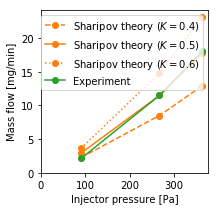

In [37]:
figsize(3, 3)

for _K, ls in zip([0.4, 0.5, 0.6], ["--", "-", ":"]):
    p0_arr = p_inj_2.copy()
    mf_arr_meas = asarray([mass_flow_interp(p_inj=p) for p in p0_arr])
    p1_arr = p_ch_2.copy()
    mf_arr_calc = asarray([mass_flow_sharipov(p0=p0*_K, p1=p1, D_lens=D_lenses[-1], verbose=False) for p0, p1 in zip(p0_arr, p1_arr)])

    plot(p0_arr, mf_arr_calc*1E6*60, "-o", label="Sharipov theory ($K = %.1f$)" % _K, ls=ls, color="C1")
plot(p0_arr, mf_arr_meas*1E6*60., "-o", label="Experiment", ls="-", color="C2")
ylabel("Mass flow [mg/min]")
xlabel("Injector pressure [Pa]")
ylim(0, None)
xlim(0, None)
legend()

## 4) Propagate pressure through entire lens stack with all methods

In [38]:
p_ch_interp(300.)

0.044921967269075394

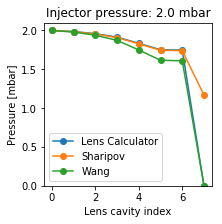

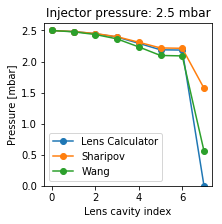

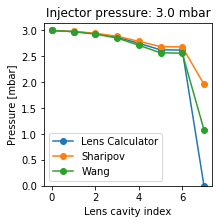

In [39]:
D_p_lenses_lenscal = {
    200.: [200.00, 198.61, 195.92, 191.51, 183.50, 175.13, 174.79, p_ch_interp(200.)],
    250.: [250.00, 248.27, 244.90, 239.39, 229.38, 218.91, 218.48, p_ch_interp(250.)],
    300.: [300.00, 297.92, 293.88, 287.27, 275.25, 262.69, 262.18, p_ch_interp(300.)],
}

for p_inj, p_lenses_lenscal in D_p_lenses_lenscal.items():
    p_lenses_sharipov = [p_inj]
    p_lenses_wang = [p_inj]

    mass_flow_fixed = mass_flow_interp(p_inj=p_lenses_sharipov[0])

    for i, (_D_lens_fixed, _D_tube_fixed) in enumerate(zip(D_lenses, D_tubes)):
        # Sharipov
        p1 = p1_sharipov(p0=p_lenses_sharipov[-1], mfn=mass_flow_fixed, D_lens=_D_lens_fixed)
        p_lenses_sharipov.append(p1)
        #print "(%i) Sharipov:\tp = %f Pa" % (i, p_lenses_sharipov[-1])

        # Wang
        p1 = p1_wang(mass_flow1=mass_flow_fixed, p0=p_lenses_wang[-1], D_lens=_D_lens_fixed, D_tube=_D_tube_fixed, do_plot=False)
        _Re = Re(D_lens=_D_lens_fixed, mass_flow=mass_flow_fixed)
        _Kn = Kn(D_lens=_D_lens_fixed, p=p_lenses_wang[-1])
        p_lenses_wang.append(p1)
        #print "(%i) Wang:\tp= %f Pa" % (i, p_lenses_wang[-1])
        
    #print p_lenses_sharipov
    #print p_lenses_wang

    figure()
    title("Injector pressure: %.1f mbar" % (p_inj/100))
    plot(asarray(p_lenses_lenscal)/100., "-o", label="Lens Calculator")
    plot(asarray(p_lenses_sharipov)/100., "-o", label="Sharipov")
    plot(asarray(p_lenses_wang)/100., "-o", label="Wang")
    ylim(0, None)
    ylabel("Pressure [mbar]")
    xlabel("Lens cavity index")
    legend()